In [ ]:
# 1. Read jsonargparse and LightningCLI docs to configure train.py
#   -> it's less hacky than using exec on a yaml file and much cleaner, but idk if it's worth the change 
#    [x] should able to pass in transformations code directly from config file
# 2. [x] Figure out logging to a file {working_dir}/{experiment_name}.log, info log the dataset creation steps
# 3. [x] Go through the dataset class and all transformations applied to them, document all functions, add logging to logfiles, hardcode root directory and file structure into the dataset module 
# 4. [x] Go through the experiment logger, document the entire process, add logging to logfiles
#    [x] add fn to plot metrics from the experiment logger, with interactive buttons to choose runs
#    [] add fn to stream metrics.csv over ssh
# 5. [] Refactor and document geovision.io.local, add SSH and S3 handlers to geovision.io.remote
# 6. [] add LR logging (train_lr_epoch), read lighting lr logger callback

# Datasets
# 1. [x] Fix Imagenet, like errors when loading images. add the default ilsvrc-2012 train/val split
# 2. Add FMOW 
# 3. Add Pascal VOC / MS COCO / OxfordIIITPets
# 4. [x] Figure out how to do transformations properly, with preprocessing, train augmentations, eval augmentations, etc.
# 5. Add geosampler for large georegistered scenes (Geo-Tiling for Semantic Segmentation)

# Analysis
# 1. Add ~efficient (numba/cupy/mojo) functions to compute image dataset statistics.

# Tests
# 1. Refactor dataset and datamodule tests. Add to test_dataset/datamodule.py to run with pytest. 
# 2. Test for expected output shapes for each sample and batch size after transformations, print any errors/inconsistencies  
# 3. Test against overlapping samples inter and intra split

In [1]:
%load_ext autoreload
%load_ext memory_profiler 
%load_ext dotenv
%autoreload 2
%dotenv

(250, 250, 3)


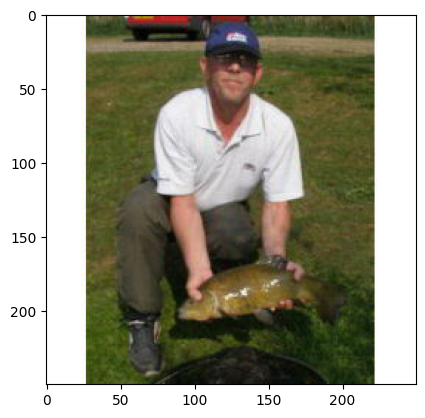

In [104]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio

with zipfile.ZipFile(Imagenet.archive) as zf:
    for idx, row in df.iterrows():
        with zf.open(row["image_path"].as_posix()) as image:
            image = iio.imread(image.read())
            # image = np.frombuffer(image.read(), dtype = np.uint8)
            print(image.shape)
            plt.imshow(image)
        break

In [3]:
import yaml
import logging
from lightning import Trainer
from geovision.config._config import ExperimentConfig
from geovision.data.module import ImageDatasetDataModule
from geovision.training.module import ClassificationModule

from geovision.io.local import get_new_dir, get_ckpt_path
from geovision.training.loggers import (
    get_csv_logger, 
    get_ckpt_logger,
    get_classification_logger
)

In [ ]:
with open("config.yaml") as f:
    config_dict = yaml.load(f, Loader=yaml.Loader)
    config_dict["dataset_params"]["random_seed"] = config_dict["random_seed"]
exec(config_dict["transforms_script"])
config_dict["dataset_params"]["image_pre"] = image_pre # type: ignore # noqa: F821
config_dict["dataset_params"]["target_pre"] = target_pre # type: ignore # noqa: F821
config_dict["dataset_params"]["train_aug"] = train_aug # type: ignore # noqa: F821
config_dict["dataset_params"]["eval_aug"] = eval_aug # type: ignore # noqa: F821
config = ExperimentConfig.model_validate(config_dict)

logger = logging.getLogger(__name__)
logging.basicConfig(
    filename = f"{get_new_dir("logs")/config.name}.log",
    filemode = "a",
    format = "%(asctime)s : %(name)s : %(levelname)s : %(message)s",
    level = logging.INFO
)
datamodule = ImageDatasetDataModule(config)

loggers: list = list()
loggers.append(csv_logger := get_csv_logger(config))

callbacks: list = list()
callbacks.append(ckpt_logger := get_ckpt_logger(config))
callbacks.append(metrics_logger := get_classification_logger(config))

In [ ]:
config = ExperimentConfig.from_config("config.yaml")
trainer = Trainer(logger = loggers, callbacks = callbacks, **config.trainer_params)
trainer.fit(ClassificationModule(config), datamodule = datamodule, ckpt_path = get_ckpt_path(config))

In [17]:
from numpy.typing import NDArray
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import Blues
from matplotlib.axes import Axes
from matplotlib.table import Table
from matplotlib.gridspec import GridSpec 
from matplotlib.widgets import RadioButtons
from geovision.config._config import ExperimentConfig
from geovision.io.local import get_experiments_dir
from geovision.analysis.viz import plot_confusion_matrix
%matplotlib tk

def plot_run_metrics(config: ExperimentConfig):
    fig = plt.figure(figsize = (15, 5), layout = "constrained")
    gs = GridSpec(nrows = 1, ncols = 5, figure = fig)
    ax = fig.add_subplot(gs[:, :4])
    rax = fig.add_subplot(gs[:, 4:])

    with h5py.File(get_experiments_dir(config)/"experiment.h5") as logfile:
        matrices, labels = list(), list()
        for run in sorted(logfile.keys()):
            logs = logfile[run]
            start, step = logs["epoch_begin"][0], logs["log_every_n_epochs"][0]
            if (val_matrices := logs.get("val_confusion_matrix_epoch")) is None:
                continue
            for idx, matrix in enumerate(val_matrices):
                matrices.append(matrix)
                labels.append(f"{run}/epoch={start + step*idx}")

    def draw_matrix(label: str): 
        plot_confusion_matrix(ax, matrices[labels.index(label)])
        ax.set_title(label, fontsize = 10)
        fig.canvas.draw()
        fig.canvas.flush_events()

    buttons = RadioButtons(rax, labels, active = 0)
    buttons.on_clicked(draw_matrix)
    buttons.set_active(0)

plot_run_metrics(ExperimentConfig.from_config("config.yaml"))

In [ ]:
import PIL
import json
import numpy as np
import pandas as pd
import imageio.v3 as iio
import rasterio as rio
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

meta: dict[str, list] = {
    "image_path": list(),
    "label_str": list(),
    "bbox": list(),
    "height": list(),
    "width": list(),
    "gsd": list(),
    "utm": list(),
    "country_code": list(),
    "cloud_cover": list(),
    "timestamp": list(),
    "bands": list()
}

fmow_path = Path.home()/"datasets"/"fmow-rgb"
fmow_json_paths = list((fmow_path/"val").rglob("*.json"))+list((fmow_path/"val").rglob("*.json"))
for json_path in tqdm(fmow_json_paths):
    with open(json_path) as fp:
        parsed = json.load(fp)
    for bbox in parsed['bounding_boxes']:
        #meta["image_path"].append(str(json_path.parent/parsed["img_filename"]).removeprefix(str(Path.home()/"datasets"/"fmow-rgb")))
        meta["image_path"].append(json_path.parent/parsed["img_filename"])
        meta["label_str"].append(bbox["category"])
        meta["bbox"].append(bbox["box"])
        meta["height"].append(parsed["img_height"])
        meta["width"].append(parsed["img_width"])
        meta["gsd"].append(parsed["gsd"])
        meta["utm"].append(parsed["utm"])
        meta["country_code"].append(parsed["country_code"])
        meta["cloud_cover"].append(parsed["cloud_cover"])
        meta["timestamp"].append(parsed["timestamp"])
        meta["bands"].append(parsed["approximate_wavelengths"])

In [ ]:
class_names = (
    'airport', 'airport_hangar', 'airport_terminal', 'amusement_park',
    'aquaculture', 'archaeological_site', 'barn', 'border_checkpoint',
    'burial_site', 'car_dealership', 'construction_site', 'crop_field',
    'dam', 'debris_or_rubble', 'educational_institution',
    'electric_substation', 'factory_or_powerplant', 'fire_station',
    'flooded_road', 'fountain', 'gas_station', 'golf_course',
    'ground_transportation_station', 'helipad', 'hospital',
    'impoverished_settlement', 'interchange', 'lake_or_pond',
    'lighthouse', 'military_facility', 'multi-unit_residential',
    'nuclear_powerplant', 'office_building', 'oil_or_gas_facility',
    'park', 'parking_lot_or_garage', 'place_of_worship',
    'police_station', 'port', 'prison', 'race_track', 'railway_bridge',
    'recreational_facility', 'road_bridge', 'runway', 'shipyard',
    'shopping_mall', 'single-unit_residential', 'smokestack',
    'solar_farm', 'space_facility', 'stadium', 'storage_tank',
    'surface_mine', 'swimming_pool', 'toll_booth', 'tower',
    'tunnel_opening', 'waste_disposal', 'water_treatment_facility',
    'wind_farm', 'zoo'
)
fmow_df = (
    pd.DataFrame(meta)
    .assign(label_idx = lambda df: df["label_str"].apply(lambda x: class_names.index(x)))
    .sort_values("label_str").reset_index(drop = True)
    .assign(bbox = lambda df: df["bbox"].astype(object))
    .assign(bands = lambda df: df["bands"].astype(object))
    .assign(timestamp = lambda df: pd.to_datetime(df["timestamp"], format='mixed'))
)
PIL.Image.MAX_IMAGE_PIXELS = fmow_df["width"].max() * fmow_df["height"].max() * 3

In [ ]:
large_image_classes = (
    "airport", "amusement_park", "impoverished_settlement", 
    "nuclear_powerplant", "port", "runway", "shipyard", "space_facility"
)
fmow_df = (
    fmow_df
    .assign(large_image_class = lambda df: df["label_str"].apply(lambda x: x in large_image_classes))
    .loc[lambda df: df["large_image_class"]]
    .drop(columns = "large_image_class")
    .reset_index(drop = True)
)

In [ ]:
for idx, row in fmow_df.iterrows():
    image = iio.imread(row["image_path"])
    print(row["bbox"])
    #bbox = Rectangle() 
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))
    ax.imshow(image)
    break

In [ ]:
heights_df = fmow_df[["label_str", "img_height"]].copy()
heights_df.columns = ("label", "dim")
heights_df["dimension"] = "height"

widths_df = fmow_df[["label_str", "img_width"]].copy()
widths_df.columns = ("label", "dim")
widths_df["dimension"] = "width"

sizes_df = pd.concat([heights_df, widths_df])
sizes_df
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
sns.boxplot(sizes_df, y = "label", x = "dim", hue = "dimension", whis = (0, 100), ax = ax[0])
sns.histplot(fmow_df["img_width"] - fmow_df["img_height"], ax = ax[1])

In [ ]:
# image height almost does not exceed its width
sns.jointplot(fmow_df, x = "img_width", y = "img_height")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (5, 10))
class_counts = fmow_df["label_str"].value_counts().reset_index()
sns.barplot(class_counts, x = "count", y = "label_str", ax = ax)


on_load_checkpoint
    epoch_begin = 0 

on_train_epoch_begin
    epoch = 0 

on_train_epoch_end
    log(metrics, epoch) -> [0, 1] 
    epoch += 1